## Setup 

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import keras 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img 
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import os

In [5]:
FAST_RUN = False
img_w = 128
img_h = 128
input_shape = (img_w, img_h)
img_c = 3

## Load data 

In [15]:
workdir = '/Users/user/Documents/Git/KaggleStruggle/Dogs_vs_Cats'
filenames = os.listdir(os.path.join(workdir, 'train'))

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


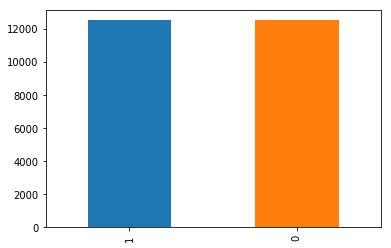

In [16]:
df['category'].value_counts().plot.bar()

### Sample image  

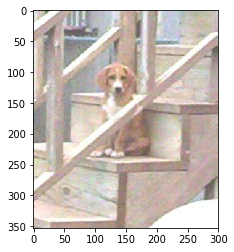

In [17]:
sample = random.choice(filenames)
image = load_img(os.path.join(workdir, 'train', sample))
plt.imshow(image)

## Build model

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

In [19]:
tf.get_default_graph().get_operations()

[]

In [21]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(img_w, img_h, img_c)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.025))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.025))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
__________

In [40]:
tf.get_default_graph().get_operations()

[<tf.Operation 'conv2d_1_input' type=Placeholder>,
 <tf.Operation 'conv2d_1/random_uniform/shape' type=Const>,
 <tf.Operation 'conv2d_1/random_uniform/min' type=Const>,
 <tf.Operation 'conv2d_1/random_uniform/max' type=Const>,
 <tf.Operation 'conv2d_1/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'conv2d_1/random_uniform/sub' type=Sub>,
 <tf.Operation 'conv2d_1/random_uniform/mul' type=Mul>,
 <tf.Operation 'conv2d_1/random_uniform' type=Add>,
 <tf.Operation 'conv2d_1/kernel' type=VariableV2>,
 <tf.Operation 'conv2d_1/kernel/Assign' type=Assign>,
 <tf.Operation 'conv2d_1/kernel/read' type=Identity>,
 <tf.Operation 'conv2d_1/Const' type=Const>,
 <tf.Operation 'conv2d_1/bias' type=VariableV2>,
 <tf.Operation 'conv2d_1/bias/Assign' type=Assign>,
 <tf.Operation 'conv2d_1/bias/read' type=Identity>,
 <tf.Operation 'conv2d_1/convolution/dilation_rate' type=Const>,
 <tf.Operation 'conv2d_1/convolution' type=Conv2D>,
 <tf.Operation 'conv2d_1/BiasAdd' type=BiasAdd>,
 <tf.Opera

## Callbacks
- To prevent overfitting, use EarlyStopping after 1- epochs and val_loass balue not decreased

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [26]:
earlystop = EarlyStopping(patience=10)

In [24]:
# Reduce learning rate when a metric has stopped improving
"""
factor: new_lr = lr * factor
patience: number of epochs with no improvement after which learning rate will be reduced.
verbose: int. 0: quiet, 1: update messages.
"""
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                             patience=2,
                             verbose=1,
                             factor=0.5,
                             min_lr=0.00001)

In [27]:
callbacks = [earlystop, reduce_lr]

### Prepare dataset 
- Train, Validation, Test set 

In [28]:
tr_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
tr_df = tr_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

total_tr = tr_df.shape[0]
total_val = val_df.shape[0]
batch_size = 15

In [30]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
filename    20000 non-null object
category    20000 non-null int64
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [31]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
filename    5000 non-null object
category    5000 non-null int64
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


### Training Generator 
- rotation: 최대 15도 회전
- width_shift_range, height_shift_range: 상하 이동 최대 10% 비율
- rescale=1./255 : 픽셀 값을 0~1범위로 전환 

In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=15, 
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [38]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=tr_df,
    directory=os.path.join(workdir, 'train/'),
    x_col='filename',
    y_col='category',
    target_size=input_shape,
    class_mode='binary',
    batch_size=batch_size
    
)

Found 20000 images belonging to 2 classes.


### Validation Generator

In [39]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(workdir, 'train/'),
    x_col='filename',
    y_col='category',
    target_size=input_shape,
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


### Generator work 

In [49]:
example_df = tr_df.sample(n=1).reset_index(drop=True)
example_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
filename    1 non-null object
category    1 non-null int64
dtypes: int64(1), object(1)
memory usage: 96.0+ bytes


In [50]:
example_df

,filename,category
0,dog.8027.jpg,1


In [51]:
example_generator = train_datagen.flow_from_dataframe(
    dataframe=example_df,
    directory=os.path.join(workdir, 'train/'),
    x_col='filename',
    y_col='category',
    target_size=input_shape,
    class_mode='binary'
)

Found 1 images belonging to 1 classes.


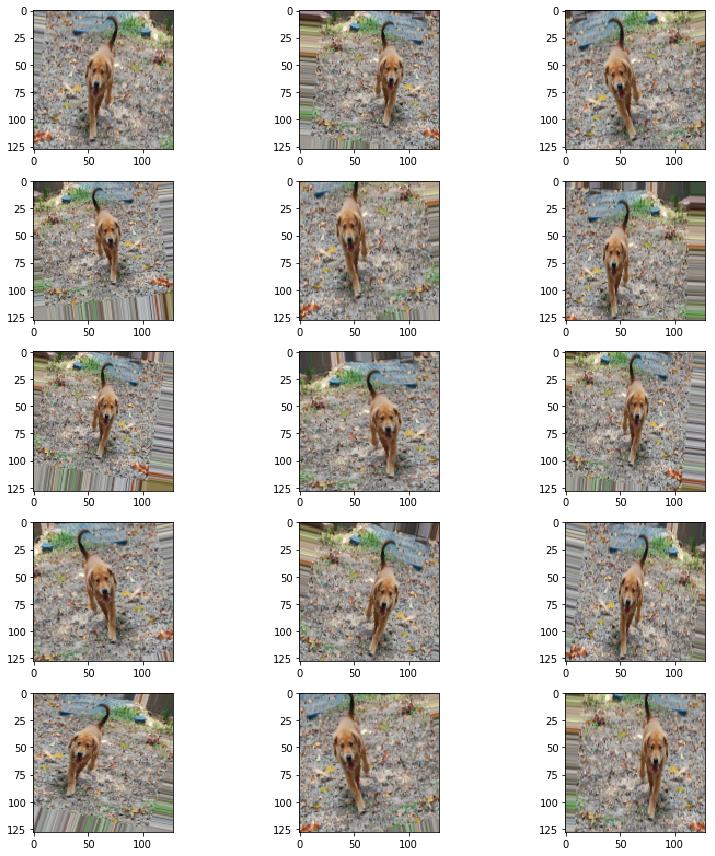

In [53]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for x_batch, y_batch in example_generator:
        image = x_batch[0]
        plt.imshow(image)
        break
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.
plt.show()

### Fit model 
- model.fit_generator: Trains the model on data generated batch-by-batch by a Python generator

In [56]:
epochs=3 # if FAST_RUN else 10
history = model.fit_generator(
    generator=train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val//batch_size,
    steps_per_epoch=total_tr//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1333/1333 [==============================] - 787s 591ms/step - loss: 0.6657 - acc: 0.5827 - val_loss: 0.6263 - val_acc: 0.6373
Epoch 2/3
1333/1333 [==============================] - 806s 605ms/step - loss: 0.5981 - acc: 0.6777 - val_loss: 0.5159 - val_acc: 0.7412
Epoch 3/3
1333/1333 [==============================] - 806s 605ms/step - loss: 0.5400 - acc: 0.7242 - val_loss: 0.4796 - val_acc: 0.7751


### Save model  

In [59]:
model.save_weights(filepath='model.h5')

### Visualize Training  

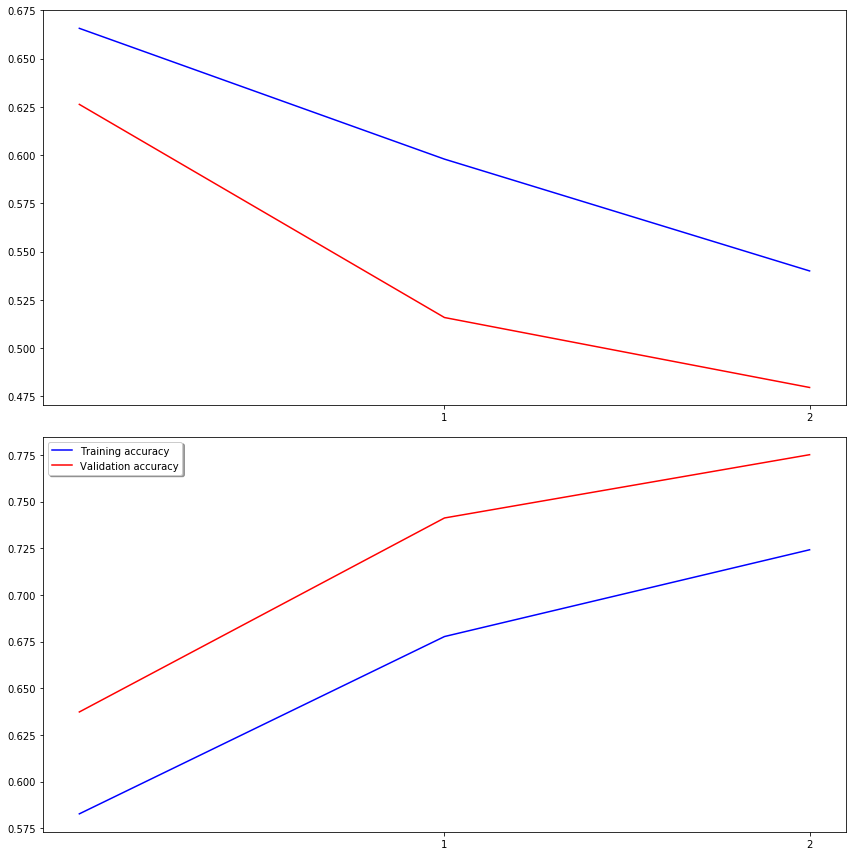

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Prepare testing data 

In [64]:
test_filenames = os.listdir(os.path.join(workdir, 'test'))
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(nb_samples)

12500


### Create Testing Generator

In [65]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(workdir, 'test/'),
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=input_shape,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


### Predict
- model.predict_generator: Generates predictions for the input samples from a data generator.

In [66]:
predict = model.predict_generator(generator=test_generator, steps=np.ceil(nb_samples/batch_size))

In [68]:
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1, 0)

### Visualize Result

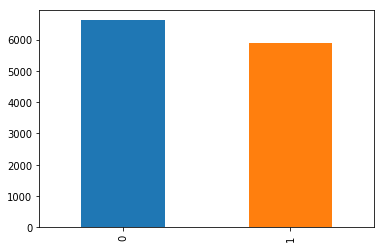

In [69]:
test_df['category'].value_counts().plot.bar()

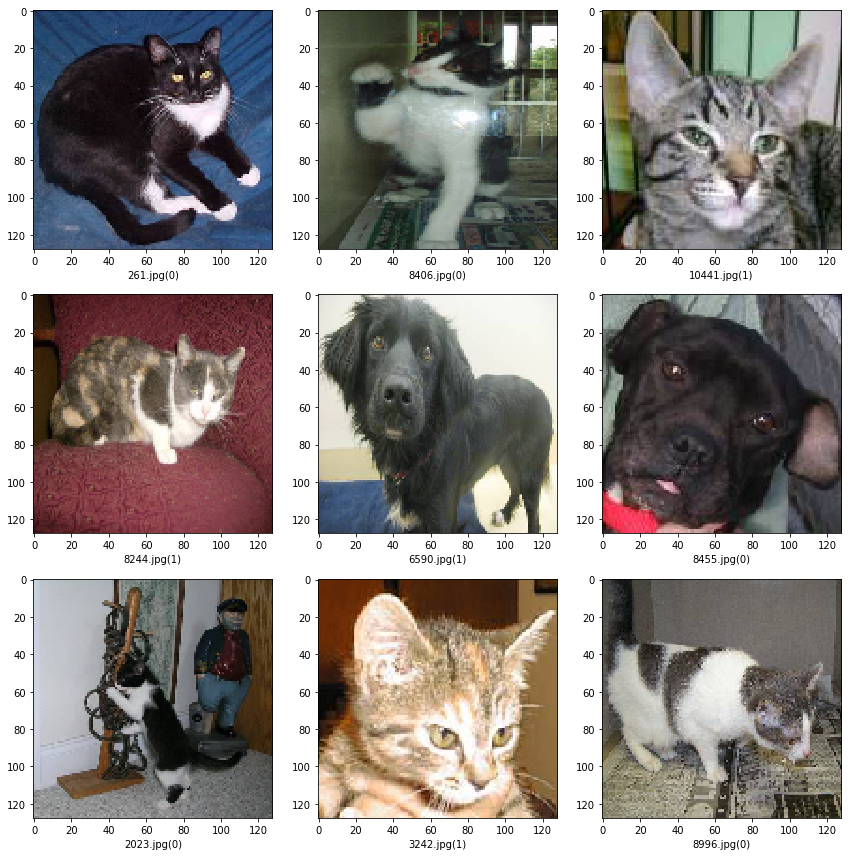

In [72]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(os.path.join(workdir, 'test/', filename), target_size=input_shape)
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename+ '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

### Submission 

In [73]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)